In [4]:
#importing libraries
from data_loader import FootballDataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Masking, GRU, Dense, Dropout, TimeDistributed, RepeatVector
)
import matplotlib.pyplot as plt

Reading game 1: Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Loading Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Data read.
Time shape: (155541, 2)
Ball shape: (155541, 5)
Team shape: (155541, 45)
Opponent shape: (155541, 48)
Total shape: (88002, 100)
Opponent name detected from filename: RFC

=== DataFrame Overview ===
Shape: (88002, 100)

Columns:
['Time', 'half', 'Ball_x', 'Ball_y', 'game', 'Ball_z', 'Ball_Col5', 'FCKplayer_1_x', 'FCKplayer_1_y', 'FCKplayer_1_number', 'FCKplayer_2_x', 'FCKplayer_2_y', 'FCKplayer_2_number', 'FCKplayer_4_x', 'FCKplayer_4_y', 'FCKplayer_4_number', 'FCKplayer_8_x', 'FCKplayer_8_y', 'FCKplayer_8_number', 'FCKplayer_10_x', 'FCKplayer_10_y', 'FCKplayer_10_number', 'FCKplayer_11_x', 'FCKplayer_11_y', 'FCKplayer_11_number', 'FCKplayer_13_x', 'FCKplayer_13_y', 'FCKplayer_13_number', 'FCKplayer_18_x', 'FCKplayer_18_y', 'FCKplayer_18_number', 'FCKplayer_24_x', 'FCKplayer_24_y', 'FCKplayer_24_number', 'FCKplayer_27_x', 'FCKplayer_27_y', 'FCKplayer_27_number', 'FCKp

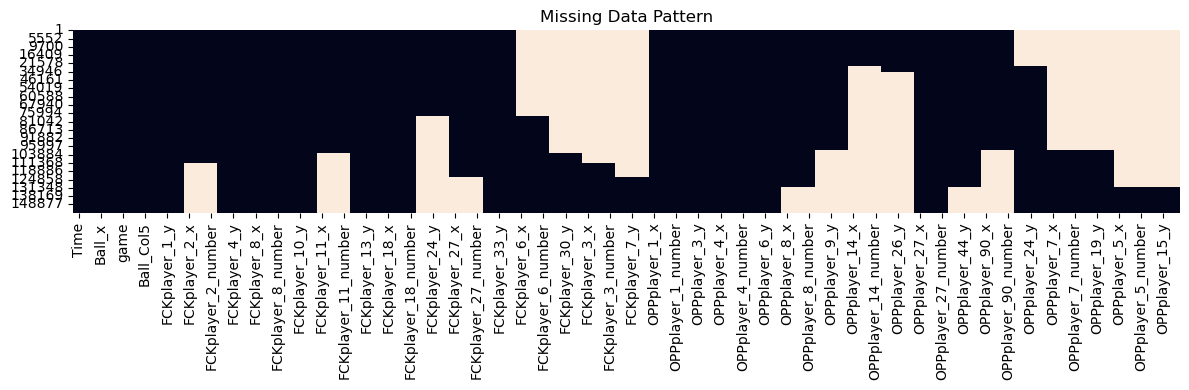

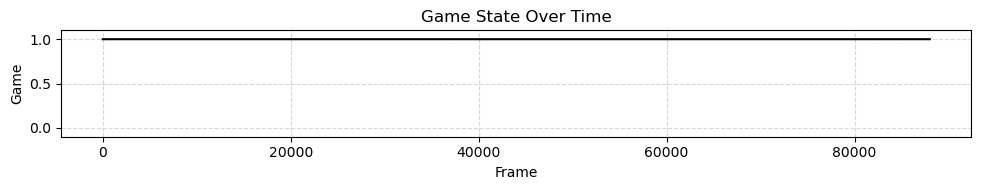

In [5]:
#loading data
#Getting the data
data_dir = r"\Users\kirlo\Documents\Sanvi University Work\Year 3\AML\final project\FootballData\RestructuredData_2425"  # replace with your actual data directory
team = "FCK"         
data_retriever = FootballDataLoader(data_dir, team)
all_games = data_retriever.load_all_games(n_games=1, speed_player= False, speed_ball=False, player_z=False, ball_z = True, )  

In [6]:
game = all_games[0]

In [7]:
#reducing columns
# Select Ball_x, Ball_y, Ball_z and all columns ending with '_x' or '_y' for players
cols = ['Ball_x', 'Ball_y', 'Ball_z'] + [col for col in game.columns if ('player' in col and (col.endswith('_x') or col.endswith('_y')))]
game = game[cols]

In [8]:
game.head()

,Ball_x,Ball_y,Ball_z,FCKplayer_1_x,FCKplayer_1_y,FCKplayer_2_x,FCKplayer_2_y,FCKplayer_4_x,FCKplayer_4_y,FCKplayer_8_x,...,OPPplayer_24_x,OPPplayer_24_y,OPPplayer_7_x,OPPplayer_7_y,OPPplayer_19_x,OPPplayer_19_y,OPPplayer_5_x,OPPplayer_5_y,OPPplayer_15_x,OPPplayer_15_y
1,-0.14,0.06,0.33,-38.63,-0.38,-15.43,-9.58,-18.34,5.17,-0.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.14,0.06,0.33,-38.64,-0.37,-15.45,-9.59,-18.34,5.17,-0.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.24,0.02,0.33,-38.65,-0.36,-15.46,-9.59,-18.35,5.17,-0.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.31,-0.01,0.33,-38.66,-0.35,-15.48,-9.59,-18.35,5.18,-0.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.38,-0.03,0.33,-38.67,-0.33,-15.50,-9.59,-18.35,5.18,-0.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def EucDist(x,y):
    return x**2 + y**2

distances = pd.DataFrame()
for col in game.columns:
    if (col.startswith('FCKplayer_') or col.startswith('OPPplayer_')) and col.endswith('_x'):
        player_prefix, player_num, _ = col.split('_')
        x_col = f'{player_prefix}_{player_num}_x'
        y_col = f'{player_prefix}_{player_num}_y'
        player_col = f'{player_prefix.lower()}_{player_num}'
        if x_col in game.columns and y_col in game.columns:
            distances[player_col] = np.sqrt((game[x_col] - game['Ball_x'])**2 + (game[y_col] - game['Ball_y'])**2)

def ball_dist (x,y,z):
    return x**2 + y**2 + z**2

distances['ball_dist'] = np.sqrt(ball_dist(game['Ball_x'], game['Ball_y'], game['Ball_z']))

In [10]:

def true_distances(player_col, ball_col='ball_dist'):
    """
    Subtracts the values of the ball column from the values of a specific player column in the distances DataFrame.

    Args:
        player_col (str): The column name for the player (e.g., 'oppplayer_15').
        ball_col (str): The column name for the ball (default is 'ball_dist').

    Returns:
        pd.Series: The result of player_col - ball_col.
    """
    return distances[player_col] - distances[ball_col]

In [11]:
scaler = StandardScaler()
distances_scaled = pd.DataFrame(
    scaler.fit_transform(distances),
    columns=distances.columns,
    index=distances.index
)

In [12]:
# Check if distances_scaled contains any 0s
contains_zero = (distances_scaled == 0).any().any()
print("Contains zero:", contains_zero)

Contains zero: False


In [13]:
#Padding the data
pad_value = 0.0
distances_scaled = np.nan_to_num(distances_scaled, nan = pad_value )

In [14]:
#Creating the sequences

sequence_length = 10  

#We train from everything except the ball
feature_columns = [col for col in distances.columns if col != 'ball_dist']
X = []
y = []

for i in range(len(distances_scaled) - sequence_length):
    X.append(distances_scaled[i:i+sequence_length, :-1])  
    y.append(distances_scaled[i+sequence_length, -1])     #y predicts the position of the ball at the next timestep

X = np.array(X)
y = np.array(y)


In [17]:
#Building RNN
model = Sequential([
    Masking(mask_value=pad_value, input_shape=(X.shape[1], X.shape[2])),
    GRU(64, return_sequences=False),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss= 'mse')

c:\Users\kirlo\anaconda3\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)
from tensorflow.keras.callbacks import EarlyStopping
#training model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.1981 - val_loss: 0.0408
Epoch 2/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0354 - val_loss: 0.0215
Epoch 3/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0200 - val_loss: 0.0206
Epoch 4/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 5/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0093 - val_loss: 0.0099
Epoch 6/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 7/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 8/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0054 - val_loss: 0.0065
Epoch 9/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 10/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 11/50
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 12/50
1760/17

In [21]:
ball_predictions = model.predict(X_test)

550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [42]:
#unnormalise and make into a df
ball_predictions_unnorm = scaler.inverse_transform(
    np.concatenate([
        np.zeros((ball_predictions.shape[0], distances.shape[1] - 1)),  # fill other features with zeros
        ball_predictions
    ], axis=1)
)[:, -1]
ball_predictions_df = pd.DataFrame(ball_predictions_unnorm, columns=['predicted_ball_dist'])

In [43]:
ball_predictions_df

,predicted_ball_dist
0,22.786139
1,33.174443
2,23.232064
3,31.465051
4,12.718465
...,...
17594,23.497045
17595,10.956849
17596,39.787044
17597,36.435462


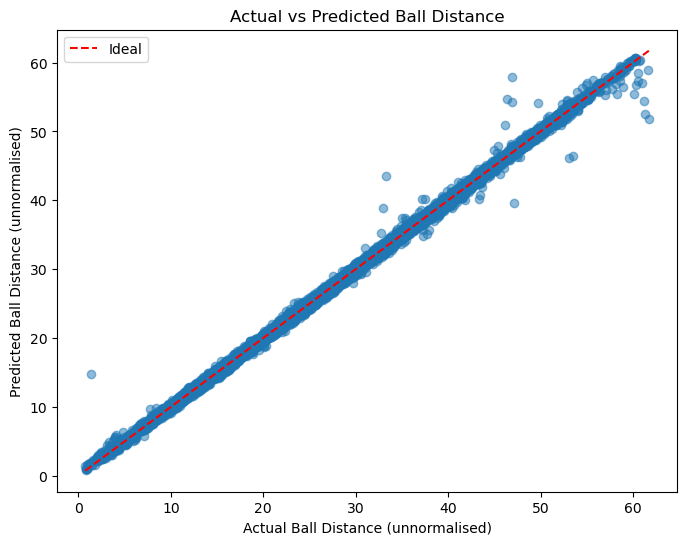

RMSE: 0.4065322295528104


In [44]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(8, 6))
plt.scatter(y_test_unnorm, ball_predictions_unnorm, alpha=0.5)
plt.xlabel('Actual Ball Distance (unnormalised)')
plt.ylabel('Predicted Ball Distance (unnormalised)')
plt.title('Actual vs Predicted Ball Distance')
plt.plot([y_test_unnorm.min(), y_test_unnorm.max()],
         [y_test_unnorm.min(), y_test_unnorm.max()],
         color='red', linestyle='--', label='Ideal')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_test_unnorm, ball_predictions_unnorm))
print("RMSE:", rmse)

In [70]:

import shap
import numpy as np
import pandas as pd

# Flatten X_test for SHAP input
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Define wrapper function to reshape flat input back to 3D
def model_predict_flat(x_flat):
    x_seq = x_flat.reshape((x_flat.shape[0], X_test.shape[1], X_test.shape[2]))
    return model.predict(x_seq)

# Select a small background sample (flattened)
background_flat = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]

# Create the SHAP explainer using the wrapper model
explainer = shap.Explainer(model_predict_flat, background_flat)

# Sample from the test set (flattened)
X_sample_flat = X_test_flat[:10]

# Compute SHAP values
shap_values = explainer(X_sample_flat, max_evals= 621, batch_size = 100)

# Aggregate SHAP values across time and samples
shap_values_mean = np.abs(shap_values.values).mean(axis=0)  # shape: (features,)

# Feature names must match the flattened input
# If each timestep has N features and T timesteps, then flattened length = T * N
# You need to create names accordingly:
T, N = X_test.shape[1], X_test.shape[2]
feature_names = [f"t{t}_f{f}" for t in range(T) for f in range(N)]

# Create DataFrame for interpretation
shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': shap_values_mean
}).sort_values('shap_importance', ascending=False)

shap_df



1479/1479 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


PermutationExplainer explainer:  20%|██        | 2/10 [00:00<?, ?it/s]

1549/1549 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
931/931 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


PermutationExplainer explainer:  40%|████      | 4/10 [00:17<00:20,  3.35s/it]

1549/1549 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
918/918 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


PermutationExplainer explainer:  50%|█████     | 5/10 [00:24<00:23,  4.79s/it]

1576/1576 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


PermutationExplainer explainer:  60%|██████    | 6/10 [00:31<00:22,  5.61s/it]

1549/1549 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
940/940 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


PermutationExplainer explainer:  70%|███████   | 7/10 [00:38<00:18,  6.04s/it]

1549/1549 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
941/941 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


PermutationExplainer explainer:  80%|████████  | 8/10 [00:45<00:12,  6.24s/it]

1479/1479 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


PermutationExplainer explainer:  90%|█████████ | 9/10 [00:51<00:06,  6.28s/it]

1576/1576 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
926/926 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


PermutationExplainer explainer: 100%|██████████| 10/10 [00:58<00:00,  6.46s/it]

1465/1465 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
912/912 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


PermutationExplainer explainer: 11it [01:04,  7.21s/it]                        


,feature,shap_importance
279,t9_f0,0.634074
294,t9_f15,0.307077
248,t8_f0,0.161605
295,t9_f16,0.128254
263,t8_f15,0.100361
...,...,...
153,t4_f29,0.000273
91,t2_f29,0.000260
30,t0_f30,0.000259
60,t1_f29,0.000250


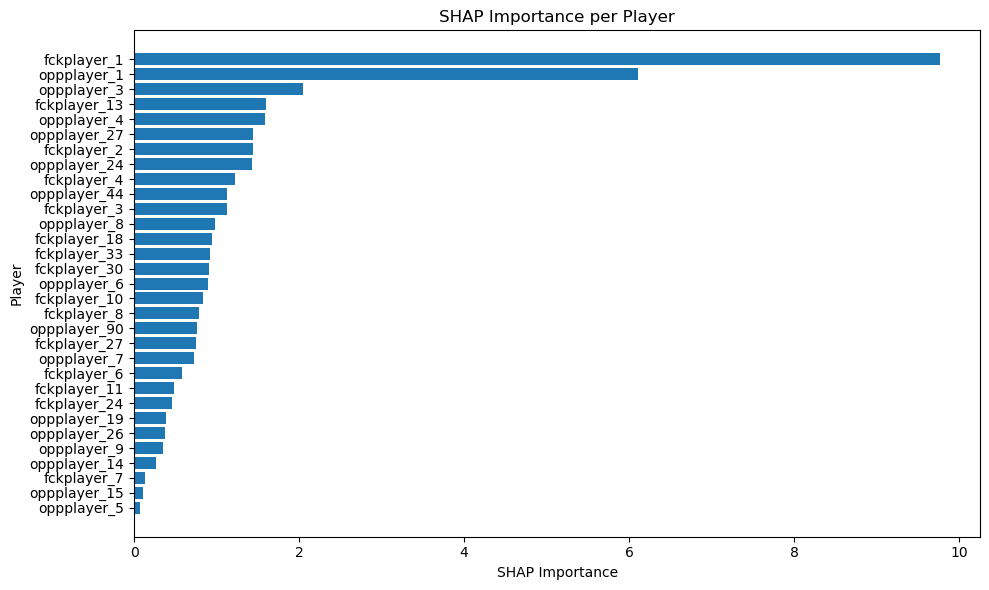

In [75]:
timesteps = X_test.shape[1]             # e.g. 10
features_per_timestep = X_test.shape[2] # e.g. 31
# feature_columns contains the player features (length 31)

# Build mapping: feature_name -> list of flat indices across all timesteps
player_feature_indices = {}
for i, feat in enumerate(feature_columns):
    indices = []
    for t in range(timesteps):
        flat_idx = t * features_per_timestep + i
        indices.append(flat_idx)
    player_feature_indices[feat] = indices

# SHAP values: shape (samples, flattened_features)
shap_vals = shap_values.values  # or explainer(...).values

# Aggregate SHAP importance per player
player_shap = {}
for player, idxs in player_feature_indices.items():
    player_shap[player] = np.abs(shap_vals[:, idxs]).sum()  # sum over all samples & time

shap_df = pd.DataFrame({
    'player': list(player_shap.keys()),
    'shap_importance': list(player_shap.values())
}).sort_values('shap_importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(shap_df['player'], shap_df['shap_importance'])
plt.xlabel('SHAP Importance')
plt.ylabel('Player')
plt.title('SHAP Importance per Player')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
